# Key Objectives
* use aord, nikkei, hsi, daxi, cac40, dji, nasdaq, spy, sp500 to predict open(t_next) - open for SPY

## 0. Library Import

In [18]:
import numpy as np
import pandas as pd
# get data
import os
from datetime import datetime
import yfinance as yf
# plot and regression
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as smf

In [3]:
import warnings
warnings.filterwarnings("ignore")

## 1. Get the Data

In [12]:
# Download
start_date = datetime(2008, 1, 1)
end_date = datetime(2021, 5,21)

# %5EAORD -> ALLOrdinary, 1330.T -> Nikkei225, %5EHSI -> HSI, 5234.TW -> DAXI, 5EFCHI -> CAC 40, %5EGSPC -> SP500
# %5EDJI -> DJI, %5EIXIC -> nasdaq_composite
indices = [r'%5EAORD', r'1330.T', r'%5EHSI', r'5234.TW', r'%5EFCHI', r'%5EGSPC', r'%5EDJI', r'%5EIXIC', 'SPY']
data = {}
for tck in indices:
    data[tck] = yf.download(tck, start_date, end_date)

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


In [19]:
# Save to Data folder
outdir = './data'
if not os.path.exists(outdir):
        os.mkdir(outdir)
        
for tck in indices:
    outname = tck + '.csv'
    fullname = os.path.join(outdir, outname)
    data[tck].to_csv(fullname)   

In [25]:
# Import all stock indices data
aord = pd.read_csv('./data/%5EAORD.csv', index_col='Date')
nikkei = pd.read_csv('./data/1330.T.csv', index_col='Date')
hsi = pd.read_csv('./data/%5EHSI.csv', index_col='Date')
daxi = pd.read_csv('./data/5234.TW.csv', index_col='Date')
cac40 = pd.read_csv('./data/%5EFCHI.csv', index_col='Date')
sp500 = pd.read_csv('./data/%5EGSPC.csv', index_col='Date')
dji = pd.read_csv('./data/%5EDJI.csv', index_col='Date')
nasdaq = pd.read_csv('./data/%5EIXIC.csv', index_col='Date')
spy = pd.read_csv('./data/SPY.csv', index_col='Date')

In [27]:
aord.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-05-14,7209.0,7281.4,7209.0,7239.4,7239.4,825354000
2021-05-17,7239.4,7297.2,7239.4,7255.8,7255.8,755818500
2021-05-18,7255.8,7314.7,7255.8,7299.1,7299.1,923042900
2021-05-19,7299.1,7299.1,7154.0,7165.7,7165.7,1049135900
2021-05-20,7252.6,7252.6,7252.6,7252.6,7252.6,0


## 2. Data Munging

In [30]:
# Due to the timezone issues, we extract and calculate appropriate stock market data for analysis
# Indicepanel is the DataFrame of our trading model
indicepanel = pd.DataFrame(index=spy.index)

# predictors from US indices
indicepanel['spy'] = spy['Open'].shift(-1) - spy['Open'] # t+1 - t
indicepanel['spy_lag1'] = indicepanel['spy'].shift(1)
indicepanel['sp500'] = sp500['Open']-sp500['Open'].shift(1) # t - t -1
indicepanel['nasdaq'] = nasdaq['Open']-nasdaq['Open'].shift(1)
indicepanel['dji'] = dji['Open']-dji['Open'].shift(1)

# predictors from Eurozone indices
indicepanel['cac40'] = cac40['Open']-cac40['Open'].shift(1) # t - t -1
indicepanel['daxi'] = daxi['Open']-daxi['Open'].shift(1)

# predictors from APAC indices
indicepanel['aord'] = aord['Close']-aord['Open'] # market already closes, data available
indicepanel['hsi'] = hsi['Close']-hsi['Open']
indicepanel['nikkei'] = nikkei['Close']-nikkei['Open']

indicepanel['Price'] = spy['Open']

In [36]:
indicepanel.head()

,spy,spy_lag1,sp500,nasdaq,dji,cac40,daxi,aord,hsi,nikkei,Price
Date,,,,,,,,,,,
2008-01-02,-1.62,NaN,NaN,NaN,NaN,NaN,NaN,15.5,-71.68,NaN,146.53
2008-01-03,-1.57,-1.62,-20.42,-41.95,-217.70,-71.78,NaN,-50.1,-162.75,NaN,144.91
2008-01-04,-1.53,-1.57,-3.54,-40.88,2.44,5.49,NaN,-2.3,515.35,NaN,143.34
2008-01-07,0.27,-1.53,-29.94,-56.93,-245.41,-111.69,NaN,-117.4,216.95,0.0,141.81
2008-01-08,-2.99,0.27,1.64,-7.18,19.75,44.51,NaN,-27.5,-354.06,0.0,142.08


In [32]:
indicepanel.shape

(3370, 11)

In [33]:
indicepanel.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3370 entries, 2008-01-02 to 2021-05-20
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   spy       3369 non-null   float64
 1   spy_lag1  3369 non-null   float64
 2   sp500     3369 non-null   float64
 3   nasdaq    3369 non-null   float64
 4   dji       3369 non-null   float64
 5   cac40     3334 non-null   float64
 6   daxi      2094 non-null   float64
 7   aord      3299 non-null   float64
 8   hsi       3211 non-null   float64
 9   nikkei    3176 non-null   float64
 10  Price     3370 non-null   float64
dtypes: float64(11)
memory usage: 315.9+ KB


In [34]:
# Check whether do we have NaN values in indicepanel
indicepanel.isnull().sum()

spy            1
spy_lag1       1
sp500          1
nasdaq         1
dji            1
cac40         36
daxi        1276
aord          71
hsi          159
nikkei       194
Price          0
dtype: int64

In [43]:
# Fill missing data with method 'fillna()' from dataframe to forward filling the Nan values
# Then we can drop the reminding Nan values, e.g. first row due to shift, or not available history data
indicepanel.fillna(method='ffill', inplace=True)
indicepanel.dropna(inplace=True)

In [44]:
# check whether do we have Nan values in indicepanel now
indicepanel.isnull().sum()

spy         0
spy_lag1    0
sp500       0
nasdaq      0
dji         0
cac40       0
daxi        0
aord        0
hsi         0
nikkei      0
Price       0
dtype: int64

In [45]:
# save this indicepanel
indicepanel.to_csv('./data/indicepanel.csv')

In [46]:
print(indicepanel.shape)

(2226, 11)


In [47]:
indicepanel.head()

,spy,spy_lag1,sp500,nasdaq,dji,cac40,daxi,aord,hsi,nikkei,Price
Date,,,,,,,,,,,
2012-07-17,0.07,0.53,-2.82,8.43,-47.60,11.18,-2.25,32.1,298.37,30.0,135.97
2012-07-18,1.61,0.07,9.90,-7.22,68.25,7.79,1.21,-18.9,-212.36,-60.0,136.04
2012-07-19,-0.70,1.61,9.43,57.47,112.63,51.45,0.78,80.0,165.60,-10.0,137.65
2012-07-20,-2.48,-0.70,3.50,-4.69,33.07,11.90,0.65,-5.8,27.02,-110.0,136.95
2012-07-23,0.72,-2.48,-14.17,-79.51,-122.23,-98.91,-0.30,-71.4,-205.89,-100.0,134.47


## 3. Data Spliting

In [48]:
# cannot use this method for time series data, order is violated
# from sklearn.model_selection import train_test_split
# Train, Test = train_test_split(indicepanel, test_size=0.3, random_state=42)
# print(Train.shape, Test.shape)

(1558, 11) (668, 11)


In [88]:
# for a 70%-30% train-test split
train_size = int(0.7 * indicepanel.shape[0])
Train = indicepanel.iloc[:train_size, :]
Test = indicepanel.iloc[train_size:, :]
print(Train.shape, Test.shape)

(1558, 11) (668, 11)


## 4. Explore the train data set

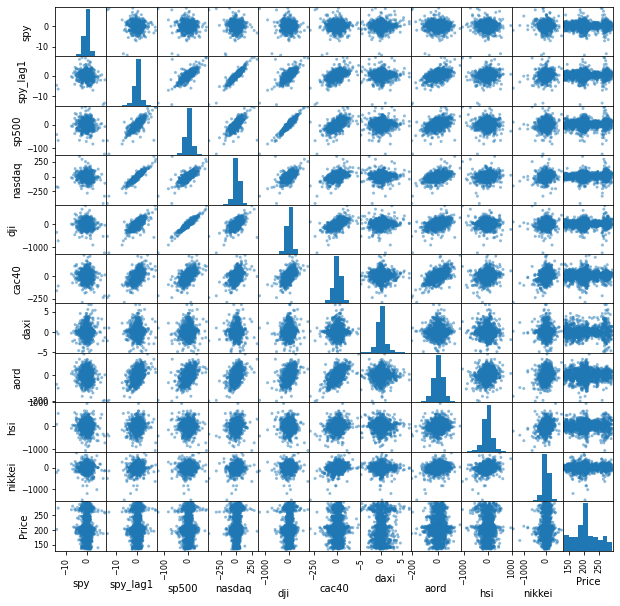

In [89]:
# Generate scatter matrix among all stock markets (and the price of SPY) to observe the association
from pandas.plotting import scatter_matrix
sm = scatter_matrix(Train, figsize=(10, 10))

## 5.Check the correlation of each index between spy

In [90]:
# Find the indice with largest correlation
corr_array = Train.iloc[:, :-1].corr()['spy']
print(corr_array)

spy         1.000000
spy_lag1   -0.070780
sp500      -0.034130
nasdaq     -0.060162
dji        -0.044091
cac40      -0.052814
daxi        0.048566
aord       -0.027795
hsi        -0.057216
nikkei     -0.026542
Name: spy, dtype: float64


In [93]:
formula = 'spy~spy_lag1+sp500+nasdaq+dji+cac40+daxi+aord+hsi+nikkei'
lm = smf.ols(formula=formula, data=Train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    spy   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     2.501
Date:                Sun, 23 May 2021   Prob (F-statistic):            0.00769
Time:                        09:26:06   Log-Likelihood:                -2930.8
No. Observations:                1558   AIC:                             5882.
Df Residuals:                    1548   BIC:                             5935.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0983      0.041      2.418      0.016       0.019       0.178
spy_lag1      -0.0977      0.076     -1.283      0.200      -0.247       0.052
sp500          0.0268      0.011      2.462      0.014       0.005       0.048
nasdaq        -0.0008      0.002     -0.360      0.719      -0.005       0.004
dji           -0.0023      0.001     -2.145      0.032      -0.004      -0.000
cac40         -0.0012      0.001     -0.974      0.330      -0.004       0.001
daxi           0.0668      0.034      1.937      0.053      -0.001       0.134
aord           0.0008      0.001      0.624      0.533      -0.002       0.003
hsi           -0.0004      0.000     -1.552      0.121      -0.001    9.36e-05
nikkei      4.996e-05      0.000      0.178      0.859      -0.001       0.001
==============================================================================
Omnibus:                      489.309   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7795.150
Skew:                          -1.027   Prob(JB):                         0.00
Kurtosis:                      13.764   Cond. No.                         379.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 6. Make prediction

In [94]:
Train['PredictedY'] = lm.predict(Train)
Test['PredictedY'] = lm.predict(Test)

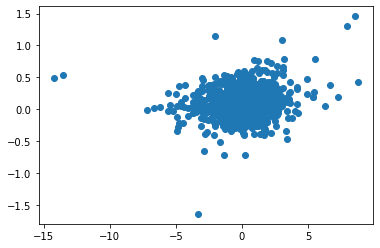

In [95]:
plt.scatter(Train['spy'],Train['PredictedY'])

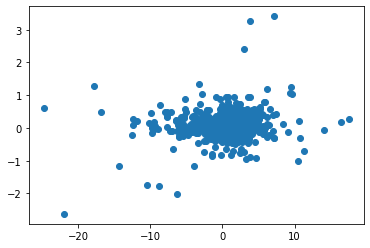

In [96]:
plt.scatter(Test['spy'],Test['PredictedY'])

## 7. Model evaluation - Statistical standard

We can measure the performance of our model using some statistical metrics - **RMSE**, **Adjusted $R^2$ **

In [97]:
# RMSE - Root Mean Squared Error, Adjusted R^2
def adjustedMetric(data, model, model_k, yname):
    data['yhat'] = model.predict(data)
    SST = ((data[yname] - data[yname].mean())**2).sum()
    SSR = ((data['yhat'] - data[yname].mean())**2).sum()
    SSE = ((data[yname] - data['yhat'])**2).sum()
    R2 = SSR / SST
    adjR2 = 1 - (1 - R2) * (data.shape[0] - 1) / (data.shape[0] - model_k - 1)
    RMSE = (SSE / (data.shape[0] - model_k - 1))**0.5
    return adjR2, RMSE

In [98]:
def accessTable(train, test, model, model_k, yname):
    r2test, RMSEtest = adjustedMetric(test, model, model_k, yname)
    r2train, RMSEtrain = adjustedMetric(train, model, model_k, yname)
    assessTbl = pd.DataFrame(index=['Adj R2','RMSE'], columns=['Train', 'Test'])
    assessTbl['Train'] = [r2train, RMSEtrain]
    assessTbl['Test'] = [r2test, RMSEtest]
    return assessTbl

In [99]:
# Get the assement table fo our model
accessTable(Train, Test, lm, 9, 'spy')

,Train,Test
Adj R2,0.008604,-0.002043
RMSE,1.592704,3.997152


## 8. Strategy evaluation

In [100]:
indicepanel.head()

,spy,spy_lag1,sp500,nasdaq,dji,cac40,daxi,aord,hsi,nikkei,Price
Date,,,,,,,,,,,
2012-07-17,0.07,0.53,-2.82,8.43,-47.60,11.18,-2.25,32.1,298.37,30.0,135.97
2012-07-18,1.61,0.07,9.90,-7.22,68.25,7.79,1.21,-18.9,-212.36,-60.0,136.04
2012-07-19,-0.70,1.61,9.43,57.47,112.63,51.45,0.78,80.0,165.60,-10.0,137.65
2012-07-20,-2.48,-0.70,3.50,-4.69,33.07,11.90,0.65,-5.8,27.02,-110.0,136.95
2012-07-23,0.72,-2.48,-14.17,-79.51,-122.23,-98.91,-0.30,-71.4,-205.89,-100.0,134.47


## Profit of Signal-based strategy

In [103]:
# Train
Train['Order'] = [1 if sig > 0 else -1 for sig in Train['PredictedY']]
Train['Profit'] = Train['spy'] * Train['Order']

Train['Wealth'] = Train['Profit'].cumsum()
print('Total profit made in Train: ', Train['Profit'].sum())

Total profit made in Train:  149.13999999999962


In [104]:
Train.tail()

,spy,spy_lag1,sp500,nasdaq,dji,cac40,daxi,aord,hsi,nikkei,Price,PredictedY,yhat,Order,Profit,Wealth
Date,,,,,,,,,,,,,,,,
2018-09-18,1.39,-1.24,-13.09,-88.64,-75.45,3.94,0.3,-24.4,238.33,370.0,289.58,0.042858,0.042858,1,1.39,149.32
2018-09-19,1.67,1.39,15.86,58.98,211.63,14.45,0.3,27.5,237.35,-60.0,290.97,-0.202257,-0.202257,-1,-1.67,147.65
2018-09-20,0.45,1.67,13.13,30.98,231.55,35.26,1.3,-20.1,-128.05,-90.0,292.64,-0.193755,-0.193755,-1,-0.45,147.20
2018-09-21,-1.75,0.45,17.03,48.16,206.86,65.46,-0.7,28.5,241.23,-10.0,293.09,-0.187264,-0.187264,-1,1.75,148.95
2018-09-24,0.19,-1.75,-14.93,-102.31,-21.00,16.98,-0.7,-5.9,-284.46,0.0,291.34,0.031253,0.031253,1,0.19,149.14


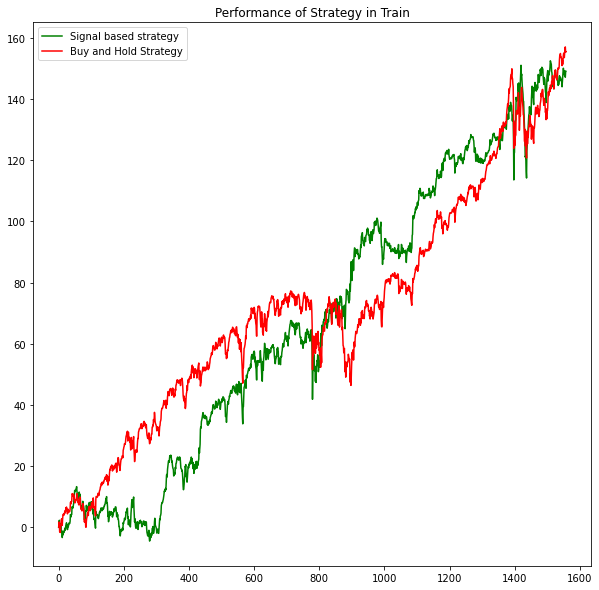

In [110]:
plt.figure(figsize=(10, 10))
plt.title('Performance of Strategy in Train')
plt.plot(Train['Wealth'].values, color='g', label='Signal based strategy')
plt.plot(Train['spy'].cumsum().values, color='r', label='Buy and Hold Strategy')
plt.legend()
plt.show()

In [112]:
# Test
Test['Order'] = [1 if sig > 0 else -1 for sig in Test['PredictedY']]
Test['Profit'] = Test['spy'] * Test['Order']

Test['Wealth'] = Test['Profit'].cumsum()
print('Total profit made in Test: ', Test['Profit'].sum())

Total profit made in Test:  137.43000000000018


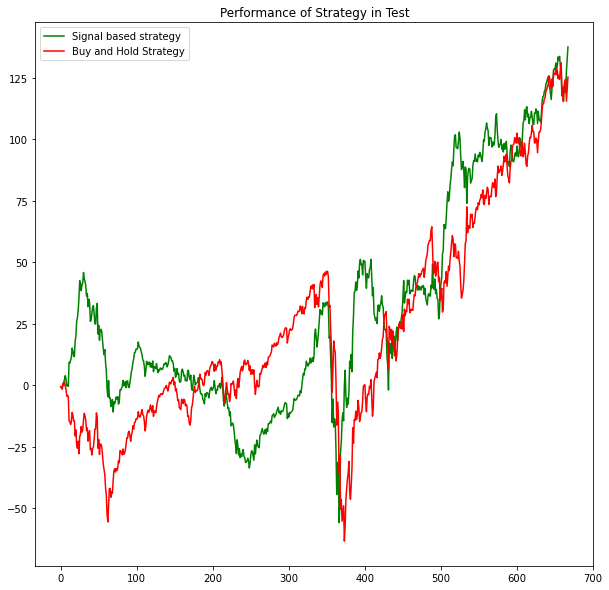

In [113]:
plt.figure(figsize=(10, 10))
plt.title('Performance of Strategy in Test')
plt.plot(Test['Wealth'].values, color='g', label='Signal based strategy')
plt.plot(Test['spy'].cumsum().values, color='r', label='Buy and Hold Strategy')
plt.legend()
plt.show()

## Evaluation of model - Practical Standard

Two common practical standards - **Sharpe Ratio**, **Maximum Drawdown** to evaluate our model performance

In [114]:
Train['Wealth'] = Train['Wealth'] + Train.loc[Train.index[0], 'Price']
Test['Wealth'] = Test['Wealth'] + Test.loc[Test.index[0], 'Price']

In [119]:
# Sharpe Ratio on Train data
Train['Return'] = np.log(Train['Wealth']) - np.log(Train['Wealth'].shift(1))
dailyr = Train['Return'].dropna()

DailySR = dailyr.mean() / dailyr.std(ddof=1)
YearlySR = (252**0.5) * DailySR

print('Daily Sharpe Ratio is ', DailySR)
print('Yearly Sharpe Ratio is ', YearlySR)

Daily Sharpe Ratio is  0.05939575590133372
Yearly Sharpe Ratio is  0.9428783942857565


In [120]:
# Sharpe Ratio on Test data
Test['Return'] = np.log(Test['Wealth']) - np.log(Test['Wealth'].shift(1))
dailyr = Test['Return'].dropna()

DailySR_test = dailyr.mean() / dailyr.std(ddof=1)
YearlySR_test = (252**0.5) * DailySR_test

print('Daily Sharpe Ratio is ', DailySR_test)
print('Yearly Sharpe Ratio is ', YearlySR_test)

Daily Sharpe Ratio is  0.044322379534562105
Yearly Sharpe Ratio is  0.7035959625784204


In [121]:
# Maximum Drawdown in Train data
Train['HWM'] = Train['Wealth'].cummax()
Train['Drawdown'] = (Train['HWM'] - Train['Wealth']) / Train['HWM'] 
print('Maximum Drawdown in Train is ', Train['Drawdown'].max())

Maximum Drawdown in Train is  0.12850076633690966


In [124]:
# Maximum Drawdown in Test data
Test['HWM'] = Test['Wealth'].cummax()
Test['Drawdown'] = (Test['HWM'] - Test['Wealth']) / Test['HWM']
print('Maximum Drawdown in Test is ', Test['Drawdown'].max())

Maximum Drawdown in Test is  0.30137554844065
